In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from functools import reduce
import shapely
from shapely.geometry import Polygon, Point

# Maximum capacity [MW]

In [2]:
onshore = pd.read_csv('../EU10CS/3_intermediate_data/areas_europe_aggregated_wind_onshore.csv',header=None, sep=" ").rename(columns={0 : 'untitled', 1 : 'area'})
offshore = pd.read_csv('../EU10CS/3_intermediate_data/areas_europe_aggregated_wind_offshore_bottom.csv', header=None, sep =" ").rename(columns={0 : 'untitled', 1 : 'area'})
solar = pd.read_csv('../EU10CS/3_intermediate_data/areas_europe_aggregated_solar.csv', header=None, sep = " ").rename(columns={0 : 'untitled', 1 : 'area'})

onshore = onshore.assign(
    country = lambda x: x.untitled.str.strip().str[-2:],
    tech = 'onshore'
).drop(columns={'untitled'})
offshore = offshore.assign(
    country = lambda x: x.untitled.str.strip().str[-2:],
    tech = 'offshore'
).drop(columns={'untitled'})
solar = solar.assign(
    country = lambda x: x.untitled.str.strip().str[-2:],
    tech = 'solar'
).drop(columns={'untitled'})

In [3]:
frames = [onshore, offshore, solar]
areas = pd.concat(frames)
areas = areas.set_index(['country','tech']).sort_index().unstack().droplevel(level=0,axis=1).fillna(0)#

In [53]:
areas

tech,offshore,onshore,solar
country,,,
AT,0.0,8772.1,3600.3
BE,2713.1,6018.6,1016.4
BG,3212.2,16087.1,11972.5
CH,0.0,552.3,1865.5
CZ,0.0,29570.3,2603.1
DE,29038.0,132204.6,10715.7
DK,63885.8,24216.0,1807.1
EE,9823.4,33286.6,3776.3
ES,3999.4,152886.1,114095.2


# Time series 

In [6]:
# Norway is in there, despite the naming convention.
wind_solar = pd.read_csv('3_intermediate_data/capacity-factors_wind-solar_europe-0_2010.csv',header=None).rename(columns={0 : 'hour', 1 : 'tech', 2 : 'zone', 3 : 'cap_fac'})

In [7]:
wind_solar

,hour,tech,zone,cap_fac
0,0,Solar,AT,0.00
1,0,Solar,BE,0.00
2,0,Solar,BG,0.00
3,0,Solar,CH,0.00
4,0,Solar,CZ,0.00
...,...,...,...,...
735835,8759,Windoffshore,RO,0.54
735836,8759,Windoffshore,SE,0.87
735837,8759,Windoffshore,SI,0.00
735838,8759,Windoffshore,SK,NaN


In [8]:
df_onshore = wind_solar.query("tech == 'Windonshore'")
df_onshore = pd.merge(df_onshore,areas.reset_index(),left_on = 'zone', right_on = 'country')
df_prod_on = df_onshore.assign(prod_onwind_MWh = lambda x : x.cap_fac * x.onshore).groupby(['zone','tech']).sum().drop(columns={'hour','cap_fac','offshore','onshore','solar'})
df_prod_on.sort_values(by='prod_onwind_MWh',ascending=False)

/tmp/ipykernel_3931254/1406635928.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_prod_on = df_onshore.assign(prod_onwind_MWh = lambda x : x.cap_fac * x.onshore).groupby(['zone','tech']).sum().drop(columns={'hour','cap_fac','offshore','onshore','solar'})


,,prod_onwind_MWh
zone,tech,
FR,Windonshore,4.704402e+08
SE,Windonshore,4.048659e+08
PL,Windonshore,3.753809e+08
FI,Windonshore,3.723119e+08
UK,Windonshore,3.201774e+08
ES,Windonshore,2.620254e+08
DE,Windonshore,2.482935e+08
NO,Windonshore,1.495037e+08
IE,Windonshore,1.066235e+08


In [9]:
df_offshore = wind_solar.query("tech == 'Windoffshore'")
df_offshore = pd.merge(df_offshore,areas.reset_index(),left_on = 'zone', right_on = 'country')
df_prod_off = df_offshore.assign(prod_offwind_MWh = lambda x : x.cap_fac * x.offshore).groupby(['zone','tech']).sum().drop(columns={'hour','cap_fac','offshore','onshore','solar'})
df_prod_off.sort_values(by='prod_offwind_MWh',ascending=False)

/tmp/ipykernel_3931254/301985981.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_prod_off = df_offshore.assign(prod_offwind_MWh = lambda x : x.cap_fac * x.offshore).groupby(['zone','tech']).sum().drop(columns={'hour','cap_fac','offshore','onshore','solar'})


,,prod_offwind_MWh
zone,tech,
UK,Windoffshore,7.051781e+08
DK,Windoffshore,3.642027e+08
NL,Windoffshore,2.403979e+08
SE,Windoffshore,2.182125e+08
DE,Windoffshore,1.593803e+08
FR,Windoffshore,1.589450e+08
NO,Windoffshore,1.420440e+08
FI,Windoffshore,9.691962e+07
PL,Windoffshore,7.038597e+07


In [10]:
df_solar = wind_solar.query("tech == 'Solar'")
df_solar = pd.merge(df_solar,areas.reset_index(),left_on = 'zone', right_on = 'country')
df_prod_sol = df_solar.assign(prod_solar_MWh = lambda x : x.cap_fac * x.solar).groupby(['zone','tech']).sum().drop(columns={'hour','cap_fac','offshore','onshore','solar'})
df_prod_sol.sort_values(by='prod_solar_MWh',ascending=False)

/tmp/ipykernel_3931254/452083866.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_prod_sol = df_solar.assign(prod_solar_MWh = lambda x : x.cap_fac * x.solar).groupby(['zone','tech']).sum().drop(columns={'hour','cap_fac','offshore','onshore','solar'})


,,prod_solar_MWh
zone,tech,
ES,Solar,1.719301e+08
NO,Solar,6.871265e+07
GR,Solar,4.910756e+07
SE,Solar,4.297759e+07
FR,Solar,4.204072e+07
PT,Solar,3.595663e+07
IT,Solar,3.595386e+07
UK,Solar,2.823648e+07
BG,Solar,1.580310e+07


In [17]:
df_prod_merged = pd.merge(pd.merge(df_prod_sol.reset_index(),df_prod_off.reset_index(),left_on = 'zone', right_on = 'zone'),df_prod_on.reset_index(),right_on = 'zone', left_on = 'zone').drop(columns={'tech_x','tech_y','tech'})

In [30]:
df_prod_merged.assign(total_prod_TWh = lambda x : (x.prod_solar_MWh + x.prod_offwind_MWh + x.prod_onwind_MWh).div(1e6)).sort_values(by = 'total_prod_TWh',ascending = False).set_index('zone')

,prod_solar_MWh,prod_offwind_MWh,prod_onwind_MWh,total_prod_TWh
zone,,,,
UK,2.823648e+07,7.051781e+08,3.201774e+08,1053.591987
FR,4.204072e+07,1.589450e+08,4.704402e+08,671.425919
SE,4.297759e+07,2.182125e+08,4.048659e+08,666.056011
FI,1.145208e+07,9.691962e+07,3.723119e+08,480.683630
PL,8.114911e+06,7.038597e+07,3.753809e+08,453.881740
DK,1.847904e+06,3.642027e+08,8.144664e+07,447.497270
ES,1.719301e+08,1.292018e+07,2.620254e+08,446.875610
DE,1.093827e+07,1.593803e+08,2.482935e+08,418.612014
NO,6.871265e+07,1.420440e+08,1.495037e+08,360.260313


# Maps

In [31]:
nuts_to_ssb = {
 'NO081': 'NO03',
 'NO082': 'NO30',
 'NO020': 'NO34',
 'NO091': 'NO38',
 'NO092': 'NO42',
 'NO0A1': 'NO11',
 'NO0A2': 'NO46',
 'NO0A3': 'NO15',
 'NO060': 'NO50',
 'NO071': 'NO18',
 'NO074': 'NO54'
 }

In [32]:
highRES_zones = pd.read_csv('../EU10CS/2_preparation_code/front_end/data/zonal_def/zones.csv')

In [33]:
len(highRES_zones)

28

In [34]:
shape_europe = gpd.read_file(
    '../../../oskar/shared_input/NUTS_RG_10M_2021_4326.geojson',
    crs = "EPSG:4326"
)

In [35]:
highRES_shape = shape_europe.copy()
highRES_shape = highRES_shape.replace({
    'EL' : 'GR',
    'GB' : 'UK',
}
)

In [36]:
highRES_shape = highRES_shape[highRES_shape['id'].isin(highRES_zones.zone)]

In [37]:
highRES_shape["center"] = highRES_shape["geometry"].centroid
highRES_shape["rep"] = highRES_shape["geometry"].representative_point()

points_europe = highRES_shape.copy()
points_europe.set_geometry("rep", inplace = True)


/tmp/ipykernel_3931254/2896830849.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  highRES_shape["center"] = highRES_shape["geometry"].centroid


In [38]:
points_europe

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,center,rep
1902,AT,AT,0,AT,Österreich,Österreich,0.0,0,0,AT,"POLYGON ((15.54245 48.90770, 15.75363 48.85218...",POINT (14.13941 47.58739),POINT (14.76527 47.69208)
1903,BE,BE,0,BE,Belgique/België,Belgique/België,0.0,0,0,BE,"POLYGON ((5.10218 51.42900, 5.08780 51.38230, ...",POINT (4.66403 50.64045),POINT (4.88182 50.50927)
1916,DK,DK,0,DK,Danmark,Danmark,0.0,0,0,DK,"MULTIPOLYGON (((14.82540 55.25410, 14.94371 55...",POINT (10.04638 55.96693),POINT (9.25017 56.24825)
1920,DE,DE,0,DE,Deutschland,Deutschland,0.0,0,0,DE,"MULTIPOLYGON (((9.42015 54.83196, 9.42293 54.8...",POINT (10.39193 51.10700),POINT (10.50451 51.09207)
1930,NL,NL,0,NL,Nederland,Nederland,0.0,0,0,NL,"MULTIPOLYGON (((6.87491 53.40801, 6.91836 53.3...",POINT (5.59203 52.26979),POINT (5.48510 52.08635)
1931,PL,PL,0,PL,Polska,Polska,0.0,0,0,PL,"MULTIPOLYGON (((18.95003 54.35831, 19.35966 54...",POINT (19.40204 52.12512),POINT (19.16210 51.92426)
1932,PT,PT,0,PT,Portugal,Portugal,0.0,0,0,PT,"MULTIPOLYGON (((-8.16508 41.81830, -8.05186 41...",POINT (-8.51520 39.59611),POINT (-8.27414 39.51375)
1934,UK,UK,0,UK,United Kingdom,United Kingdom,0.0,0,0,UK,"MULTIPOLYGON (((-0.24042 51.49011, -0.22283 51...",POINT (-2.90206 54.16183),POINT (-1.91798 54.31086)
1941,ES,ES,0,ES,España,España,0.0,0,0,ES,"MULTIPOLYGON (((4.28746 39.82237, 4.24593 39.8...",POINT (-3.64487 40.22683),POINT (-3.46921 39.89173)
1951,BG,BG,0,BG,Bulgaria,България,0.0,0,0,BG,"POLYGON ((22.99717 43.80787, 23.25146 43.83394...",POINT (25.23565 42.75840),POINT (25.17412 42.73254)


In [39]:
highRES_shape_coords = highRES_shape.copy()

In [40]:
highRES_shape_coords = highRES_shape_coords.assign(
    x_coord_center = lambda x: x.center.x,
    y_coord_center = lambda x: x.center.y,
    x_coord_rep = lambda x: x.rep.x,
    y_coord_rep = lambda x: x.rep.y
)

In [41]:
highRES_shape_coords.at[1984,'x_coord_rep'] = 9 #Norway
highRES_shape_coords.at[1984,'y_coord_rep'] = 61 #Norway

In [42]:
points_europe.at[1984,'rep'] = Point(9,61)

In [43]:
df_trans = pd.read_csv(
    '../../../oskar/shared_input/transmission_lines.tsv', 
    sep = "\t",
).drop(
    columns={
        'links_cap',
        'links_dist',
    }
)


In [44]:
df_trans_overhead = df_trans.loc[df_trans['Tech'] == "HVAC400KV"]
df_trans_subsea = df_trans.loc[df_trans['Tech'] == "HVDCSubsea"]#.reset_index(drop=True)

In [45]:
pd.options.mode.chained_assignment = None  # default='warn'

df_trans_overhead['x1_coord'] = None
df_trans_overhead['y1_coord'] = None
df_trans_overhead['x2_coord'] = None
df_trans_overhead['y2_coord'] = None

for i in range(len(df_trans_overhead.index)):
    df_trans_overhead.x1_coord.iloc[i] = highRES_shape_coords.loc[highRES_shape_coords['id'] == df_trans_overhead.Zone1.iloc[i]].x_coord_rep.to_numpy()[0]
    df_trans_overhead.y1_coord.iloc[i] = highRES_shape_coords.loc[highRES_shape_coords['id'] == df_trans_overhead.Zone1.iloc[i]].y_coord_rep.to_numpy()[0]
    df_trans_overhead.x2_coord.iloc[i] = highRES_shape_coords.loc[highRES_shape_coords['id'] == df_trans_overhead.Zone2.iloc[i]].x_coord_rep.to_numpy()[0]
    df_trans_overhead.y2_coord.iloc[i] = highRES_shape_coords.loc[highRES_shape_coords['id'] == df_trans_overhead.Zone2.iloc[i]].y_coord_rep.to_numpy()[0]


In [46]:
pd.options.mode.chained_assignment = None  # default='warn'

df_trans_subsea['x1_coord'] = None
df_trans_subsea['y1_coord'] = None
df_trans_subsea['x2_coord'] = None
df_trans_subsea['y2_coord'] = None

for i in range(len(df_trans_subsea.index)):
    df_trans_subsea.x1_coord.iloc[i] = highRES_shape_coords.loc[highRES_shape_coords['id'] == df_trans_subsea.Zone1.iloc[i]].x_coord_rep.to_numpy()[0]
    df_trans_subsea.y1_coord.iloc[i] = highRES_shape_coords.loc[highRES_shape_coords['id'] == df_trans_subsea.Zone1.iloc[i]].y_coord_rep.to_numpy()[0]
    df_trans_subsea.x2_coord.iloc[i] = highRES_shape_coords.loc[highRES_shape_coords['id'] == df_trans_subsea.Zone2.iloc[i]].x_coord_rep.to_numpy()[0]
    df_trans_subsea.y2_coord.iloc[i] = highRES_shape_coords.loc[highRES_shape_coords['id'] == df_trans_subsea.Zone2.iloc[i]].y_coord_rep.to_numpy()[0]


In [47]:
df_trans_overhead

,Zone1,Zone2,Tech,x1_coord,y1_coord,x2_coord,y2_coord
0,AT,HU,HVAC400KV,14.765275,47.692075,19.148747,47.16381
1,AT,CZ,HVAC400KV,14.765275,47.692075,15.532839,49.806815
2,AT,CH,HVAC400KV,14.765275,47.692075,8.448019,46.808085
3,AT,DE,HVAC400KV,14.765275,47.692075,10.504506,51.09207
4,AT,SI,HVAC400KV,14.765275,47.692075,14.630981,46.15812
5,AT,IT,HVAC400KV,14.765275,47.692075,12.674732,42.50005
6,BE,LU,HVAC400KV,4.881817,50.50927,6.120359,49.811485
7,BE,FR,HVAC400KV,4.881817,50.50927,2.187452,46.727085
8,BE,NL,HVAC400KV,4.881817,50.50927,5.4851,52.086355
9,BE,DE,HVAC400KV,4.881817,50.50927,10.504506,51.09207


In [49]:
highRES_shape[['NUTS_ID','geometry']].rename(columns={'NUTS_ID' : 'country'})

,country,geometry
1902,AT,"POLYGON ((15.54245 48.90770, 15.75363 48.85218..."
1903,BE,"POLYGON ((5.10218 51.42900, 5.08780 51.38230, ..."
1916,DK,"MULTIPOLYGON (((14.82540 55.25410, 14.94371 55..."
1920,DE,"MULTIPOLYGON (((9.42015 54.83196, 9.42293 54.8..."
1930,NL,"MULTIPOLYGON (((6.87491 53.40801, 6.91836 53.3..."
1931,PL,"MULTIPOLYGON (((18.95003 54.35831, 19.35966 54..."
1932,PT,"MULTIPOLYGON (((-8.16508 41.81830, -8.05186 41..."
1934,UK,"MULTIPOLYGON (((-0.24042 51.49011, -0.22283 51..."
1941,ES,"MULTIPOLYGON (((4.28746 39.82237, 4.24593 39.8..."
1951,BG,"POLYGON ((22.99717 43.80787, 23.25146 43.83394..."


In [54]:
areas = pd.concat(frames)

In [60]:
gdf_brownfield = df_prod_merged.rename(columns={'zone' : 'country', 'prod_solar_MWh' : 'solar', 'prod_offwind_MWh' : 'offshore', 'prod_onwind_MWh' : 'onshore'}).merge(
    highRES_shape[['NUTS_ID','geometry']].rename(columns={'NUTS_ID' : 'country'})
).set_index('country').fillna(0).assign(total = lambda x : x.offshore + x.onshore + x.solar)
gdf_brownfield

,solar,offshore,onshore,geometry,total
country,,,,,
AT,4.229308e+06,0.000000e+00,1.373527e+07,"POLYGON ((15.54245 48.90770, 15.75363 48.85218...",1.796457e+07
BE,1.034919e+06,1.347472e+07,1.403273e+07,"POLYGON ((5.10218 51.42900, 5.08780 51.38230, ...",2.854237e+07
BG,1.580310e+07,1.057694e+07,2.496477e+07,"POLYGON ((22.99717 43.80787, 23.25146 43.83394...",5.134481e+07
CH,2.372375e+06,0.000000e+00,3.354781e+05,"POLYGON ((8.67046 47.68486, 8.79571 47.67560, ...",2.707853e+06
CZ,2.690356e+06,0.000000e+00,4.716315e+07,"POLYGON ((14.31787 51.05470, 14.41509 51.02507...",4.985351e+07
DE,1.093827e+07,1.593803e+08,2.482935e+08,"MULTIPOLYGON (((9.42015 54.83196, 9.42293 54.8...",4.186120e+08
DK,1.847904e+06,3.642027e+08,8.144664e+07,"MULTIPOLYGON (((14.82540 55.25410, 14.94371 55...",4.474973e+08
EE,3.527668e+06,4.804812e+07,7.842889e+07,"MULTIPOLYGON (((25.83016 59.56406, 25.88224 59...",1.300047e+08
ES,1.719301e+08,1.292018e+07,2.620254e+08,"MULTIPOLYGON (((4.28746 39.82237, 4.24593 39.8...",4.468756e+08


In [89]:
highRES_shape_slim = highRES_shape[['NUTS_ID','geometry']].rename(columns={'NUTS_ID' : 'country'}).assign(
    center = lambda x : x.geometry.centroid,
    x_coord = lambda x : x.centroid.x,
    y_coord = lambda x : x.centroid.y,
).set_index('country')

/tmp/ipykernel_3931254/564548292.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = lambda x : x.geometry.centroid,
/tmp/ipykernel_3931254/564548292.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_coord = lambda x : x.centroid.x,
/tmp/ipykernel_3931254/564548292.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_coord = lambda x : x.centroid.y,


Text(0.5, 1.0, 'Transmission grid')

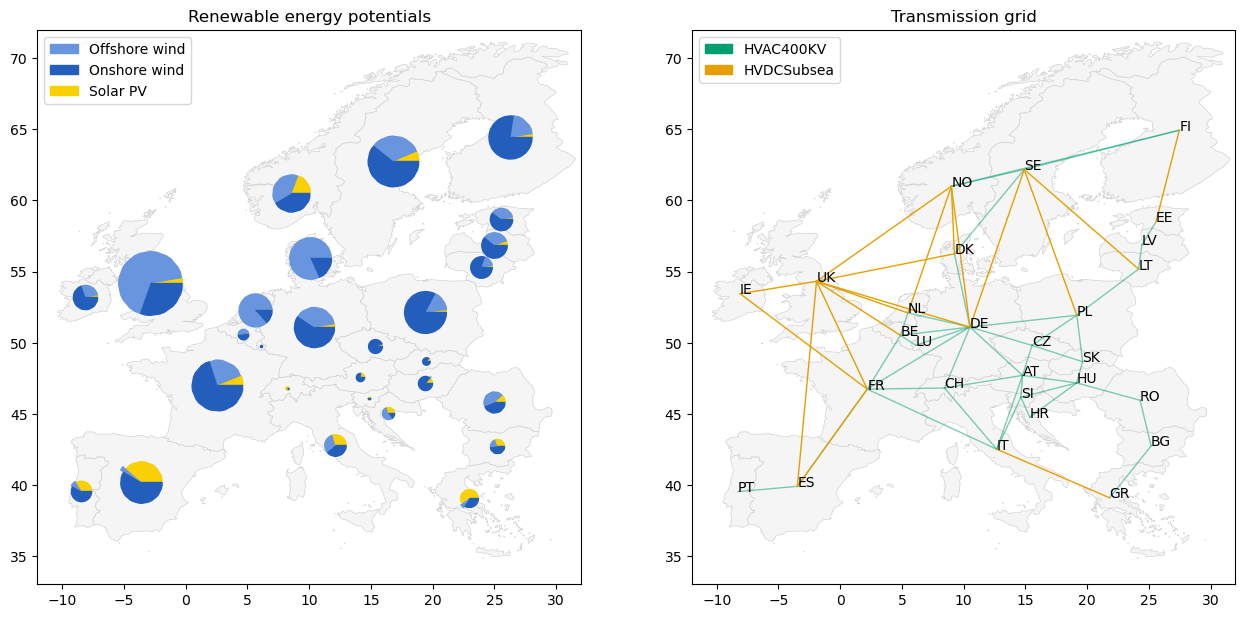

In [97]:
highRES_shape_slim.at['NO', 'x_coord'] = 8.5
highRES_shape_slim.at['NO', 'y_coord'] = 60.5
highRES_shape_slim.at['FR', 'x_coord'] = 2.5
highRES_shape_slim.at['FR', 'y_coord'] = 47

pieList = []

for country in gdf_brownfield.index.unique():
    wedges = []
    for i in range(3):
        temp = abs(gdf_brownfield.reset_index().query("country == @country").iloc[0][i+1])
        wedges.append(temp)
        #print(temp)
    pie = plt.pie(wedges,
                 colors = [
                    '#f9d002',
                     '#6895dd',
                    '#235ebc',
        ])
    plt.close()
    pieList.append(pie)

piecolors = [
    '#f9d002',
    '#6895dd',
    '#235ebc',
]

solar = mpatches.Patch(color='#f9d002', label='Solar PV')
offshore = mpatches.Patch(color='#6895dd', label='Offshore wind')
onshore = mpatches.Patch(color='#235ebc', label='Onshore wind')


first_legend = plt.legend(
    handles=[
        solar,
        offshore,
        onshore,
    ], 
    loc = 'upper left'
)

plt.close()

fig, axes = plt.subplots(1, 2, figsize=(12, 7.2))
fig.subplots_adjust(left=0, right=1)

for i in range(len(gdf_brownfield.index.unique())):
    #print(norway_shape.iloc[i])
    name = highRES_shape_slim.sort_index().iloc[i].name
    for j in range(3):
        axes[0].scatter(
            highRES_shape_slim.sort_index().x_coord[i],
            highRES_shape_slim.sort_index().y_coord[i],
            marker=(
                pieList[i][0][j].get_path().vertices.tolist()
            ),
            facecolor=piecolors[j], 
            s=gdf_brownfield.loc[name].total/5e5,
            zorder=10
        )

highRES_shape.plot(
    ax = axes[0],
    color = "whitesmoke", 
    edgecolor = "lightgrey", 
    linewidth = 0.5
)        
        
highRES_shape.plot(
    ax = axes[1],
    color = "whitesmoke", 
    edgecolor = "lightgrey", 
    linewidth = 0.5
)

texts = []

for x, y, label in zip(points_europe.rep.x, points_europe.rep.y, points_europe["id"]):
    texts.append(plt.text(x, y, label, fontsize = 10))
    
# plot overhead cables
for i in range(len(df_trans_overhead.index)):
    plt.plot(
        [df_trans_overhead.x1_coord.iloc[i],df_trans_overhead.x2_coord.iloc[i]],
        [df_trans_overhead.y1_coord.iloc[i],df_trans_overhead.y2_coord.iloc[i]],
        '#009E73',
        linewidth = 1,
        alpha = 0.5
    )  

#plot subsea cables
for i in range(len(df_trans_subsea.index)):
    plt.plot(
        [df_trans_subsea.x1_coord.iloc[i],df_trans_subsea.x2_coord.iloc[i]],
        [df_trans_subsea.y1_coord.iloc[i],df_trans_subsea.y2_coord.iloc[i]],
        '#E69F00',
        linewidth = 1,
        alpha = 1,
    )      
    
axes[0].legend(handles=[offshore,onshore,solar], loc = 'upper left')
    
ax.set_axis_off()
axes[0].set_xlim([-12,32])
axes[0].set_ylim([33,72])
axes[1].set_xlim([-12,32])
axes[1].set_ylim([33,72])

overhead = mpatches.Patch(color='#009E73', label='HVAC400KV')
subsea = mpatches.Patch(color='#E69F00', label='HVDCSubsea')
plt.legend(handles=[overhead,subsea],loc="upper left")

axes[0].set_title('Renewable energy potentials')
axes[1].set_title('Transmission grid')

#plt.savefig('brownfield_capacities.pdf',bbox_inches = 'tight')

In [98]:
gdf_brownfield

,solar,offshore,onshore,geometry,total
country,,,,,
AT,4.229308e+06,0.000000e+00,1.373527e+07,"POLYGON ((15.54245 48.90770, 15.75363 48.85218...",1.796457e+07
BE,1.034919e+06,1.347472e+07,1.403273e+07,"POLYGON ((5.10218 51.42900, 5.08780 51.38230, ...",2.854237e+07
BG,1.580310e+07,1.057694e+07,2.496477e+07,"POLYGON ((22.99717 43.80787, 23.25146 43.83394...",5.134481e+07
CH,2.372375e+06,0.000000e+00,3.354781e+05,"POLYGON ((8.67046 47.68486, 8.79571 47.67560, ...",2.707853e+06
CZ,2.690356e+06,0.000000e+00,4.716315e+07,"POLYGON ((14.31787 51.05470, 14.41509 51.02507...",4.985351e+07
DE,1.093827e+07,1.593803e+08,2.482935e+08,"MULTIPOLYGON (((9.42015 54.83196, 9.42293 54.8...",4.186120e+08
DK,1.847904e+06,3.642027e+08,8.144664e+07,"MULTIPOLYGON (((14.82540 55.25410, 14.94371 55...",4.474973e+08
EE,3.527668e+06,4.804812e+07,7.842889e+07,"MULTIPOLYGON (((25.83016 59.56406, 25.88224 59...",1.300047e+08
ES,1.719301e+08,1.292018e+07,2.620254e+08,"MULTIPOLYGON (((4.28746 39.82237, 4.24593 39.8...",4.468756e+08
